In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Fri Oct 21 04:57:46 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   60C    P8    11W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 13.6 gigabytes of available RAM

Not using a high-RAM runtime


In [ ]:
! pip install --upgrade gensim

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 24.1 MB 1.6 MB/s 
  Attempting uninstall: gensim
    Found existing installation: gensim 3.6.0
    Uninstalling gensim-3.6.0:
      Successfully uninstalled gensim-3.6.0


In [ ]:
!pip install tensorflow-addons

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.1 MB 7.9 MB/s 


In [ ]:

import json
import ast
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
from random import sample
from collections import OrderedDict



#Sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.preprocessing import StandardScaler

#matplot
import matplotlib.pyplot as plt



#embedding
from gensim.models import Word2Vec
from gensim.test.utils import get_tmpfile
from gensim.models.callbacks import CallbackAny2Vec
from gensim.models.callbacks import PerplexityMetric
# tqdm
from tqdm.notebook import tqdm

#tensorflow
from keras_preprocessing.sequence import pad_sequences
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras.layers import Embedding, Flatten,Dense
from tensorflow import keras
from keras import backend as K
from keras import callbacks
import tensorflow_addons as tfa

#os
import os




# Load Data And EDA

In [ ]:
train_file_path = "/content/drive/MyDrive/SML_assign/comp90051-22-s2-authorship/train.json"
test_file_path = "/content/drive/MyDrive/SML_assign/comp90051-22-s2-authorship/test.json"

with open(train_file_path, 'r') as f:
    train_data = json.load(f)

with open(test_file_path, 'r') as f:
    test_data = json.load(f)


## Coauthor one-hot encoding

In [ ]:
#Find the coauthor who has already cooperated with prolific author
def preprocess_coauthor(data):
  cooperate_coauthor = {}
  cooperate_coauthor_index = {}
  for i in data:
    authors = np.array(i['authors'])
    prolific_author = authors[authors < 100]
    non_prolific_authors = authors[authors >= 100]
    if len(prolific_author) != 0:
      for i in non_prolific_authors:
        cooperate_coauthor[i] = 1
  for i,j in enumerate(list(cooperate_coauthor.keys())):
    cooperate_coauthor_index[j] = i
  return cooperate_coauthor,cooperate_coauthor_index

cooperate_coauthor,cooperate_coauthor_index = preprocess_coauthor(train_data)

# One hot encoding these coauthors

def ohe_coauthor(data,cooperate_coauthor_index):
  ohe_coauthor = []
  for i in tqdm(data):
    authors = np.array(i['authors'])
    prolific_author = authors[authors < 100]
    non_prolific_authors = authors[authors >= 100]
    per_ohe_cauthor = np.zeros(len(cooperate_coauthor_index) + 1)
    for j in non_prolific_authors:
      if j in list(cooperate_coauthor_index.keys()):
        per_ohe_cauthor[cooperate_coauthor_index[j]] = 1
      else:
        per_ohe_cauthor[-1] =1
    ohe_coauthor.append(per_ohe_cauthor)
  return np.array(ohe_coauthor).astype('float64')




## abstract and title gensim word to vec

In [ ]:
# concate abstract and title
def stack_abstract_title(data):
  total_abstract = []
  total_title = []
  for i in data:
    abstract = i['abstract']
    title = i['title']
    total_abstract.append(abstract)
    total_title.append(title)
  return total_abstract + total_title

stacked_title_abstract = stack_abstract_title(train_data)




class EpochLogger(CallbackAny2Vec):
  def __init__(self):
      self.epoch = 0
  def on_epoch_begin(self, model):
      print("Epoch #{} start".format(self.epoch))
  def on_epoch_end(self, model):
         print("Epoch #{} end".format(self.epoch))
         self.epoch += 1

     

epoch_logger = EpochLogger()      

title_abstract_model = Word2Vec(sentences=stacked_title_abstract, vector_size=128, window=5, min_count=1, workers=4,callbacks=[epoch_logger],epochs=10)




Epoch #0 start
Epoch #0 end
Epoch #1 start
Epoch #1 end
Epoch #2 start
Epoch #2 end
Epoch #3 start
Epoch #3 end
Epoch #4 start
Epoch #4 end
Epoch #5 start
Epoch #5 end
Epoch #6 start
Epoch #6 end
Epoch #7 start
Epoch #7 end
Epoch #8 start
Epoch #8 end
Epoch #9 start
Epoch #9 end


In [ ]:
def get_vector_rep(model,data):
  total_vec = []
  for i in tqdm(data):
    title = i['title']
    abstract = i['abstract']
    concate = title + abstract
    per_sentence = np.zeros(128)
    for i in concate:
      per_sentence = per_sentence + model.wv[i]
    per_sentence = per_sentence/len(concate)
    total_vec.append(per_sentence)
  return np.array(total_vec)


## One-hot-encoding venue and year

In [ ]:
def ohe_venue(data):
  ohe_venue = []
  for i in tqdm(data):
    per_instance_venue = np.zeros(466)
    venue = i['venue']
    if venue == '':
      per_instance_venue[-1] = 1.
    else:
      per_instance_venue[venue] = 1.
    ohe_venue.append(per_instance_venue)
  return np.array(ohe_venue)





## One-hot-encoding labels

In [ ]:
def ohe_labels(data):
  total_label = []
  for i in tqdm(data):
    labels = np.zeros(101)
    total_author = np.array(i['authors'])
    prolific_author = total_author[total_author < 100]
    if len(prolific_author) != 0:
      labels[prolific_author] = 1.
    else:
      labels[-1] = 1.
    total_label.append(labels)
  return np.array(total_label)






## concate all the features and save them to npy file (train and test)

In [ ]:
title_abs_rep = get_vector_rep(title_abstract_model,train_data)

  0%|          | 0/25793 [00:00<?, ?it/s]

In [ ]:
train_ohe_coauthor = ohe_coauthor(train_data,cooperate_coauthor_index)
venue = ohe_venue(train_data)
train_features = np.concatenate((train_ohe_coauthor,title_abs_rep,venue),axis = 1)

labels = ohe_labels(train_data)


  0%|          | 0/25793 [00:00<?, ?it/s]

  0%|          | 0/25793 [00:00<?, ?it/s]

  0%|          | 0/25793 [00:00<?, ?it/s]

In [ ]:

def test_ohe_coauthor(data,cooperate_coauthor_index):
  ohe_coauthor = []
  for i in tqdm(data):
    authors = np.array(i['coauthors'])
    per_ohe_cauthor = np.zeros(len(cooperate_coauthor_index) + 1)
    for j in authors:
      if j in cooperate_coauthor_index.keys():
        per_ohe_cauthor[cooperate_coauthor_index[j]] = 1
      else:
        per_ohe_cauthor[-1] = 1
    ohe_coauthor.append(per_ohe_cauthor)
  return np.array(ohe_coauthor).astype('float64')

In [ ]:
test_ohe_coauthor = test_ohe_coauthor(test_data,cooperate_coauthor_index)
test_title_abs_rep = get_vector_rep(title_abstract_model,test_data)
test_ohe_venue = ohe_venue(test_data)
# test_year = year_vector(test_data)

test_features = np.concatenate((test_ohe_coauthor,test_title_abs_rep,test_ohe_venue),axis = 1)
test_features.shape

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

(800, 7170)

In [ ]:
scaler = StandardScaler()
train_features = scaler.fit_transform(train_features)

In [ ]:
X_train,X_test,y_train,y_test = train_test_split(train_features,labels,test_size=0.2,random_state=90051)

## Tensorflow

In [ ]:
inputs = keras.Input(shape = train_features.shape[1],)
dense1 = layers.Dense(2048,activation = 'tanh')(inputs)
dp1 = layers.Dropout(0.3)(dense1)
dense2 = layers.Dense(1024,activation = 'tanh')(dp1)
dp2 = layers.Dropout(0.3)(dense2)
dense3 = layers.Dense(512,activation = 'tanh')(dp2)
dp3 = layers.Dropout(0.3)(dense3)
dense4 = layers.Dense(256,activation = 'tanh')(dp3)
dp4 = layers.Dropout(0.3)(dense4)
dense5 = layers.Dense(labels.shape[1],activation = 'sigmoid')(dp4)

model = keras.Model(inputs, dense5)
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 7170)]            0         
                                                                 
 dense_5 (Dense)             (None, 2048)              14686208  
                                                                 
 dropout_4 (Dropout)         (None, 2048)              0         
                                                                 
 dense_6 (Dense)             (None, 1024)              2098176   
                                                                 
 dropout_5 (Dropout)         (None, 1024)              0         
                                                                 
 dense_7 (Dense)             (None, 512)               524800    
                                                                 
 dropout_6 (Dropout)         (None, 512)               0   

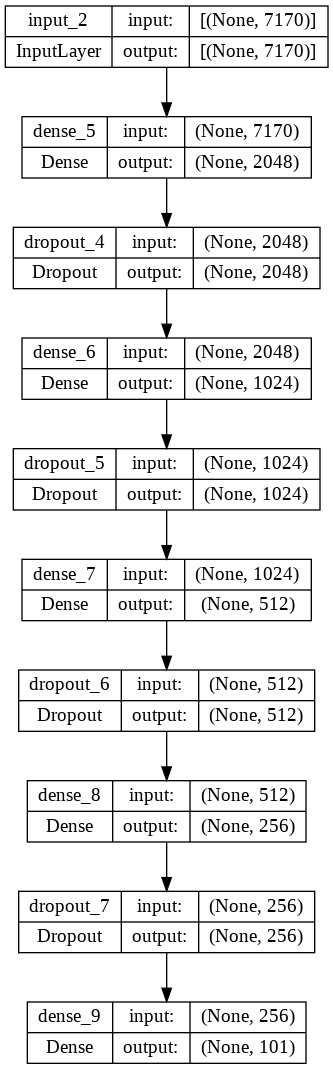

In [ ]:
keras.utils.plot_model(model, "my_first_model_with_shape_info.png", show_shapes=True)

In [ ]:
metrics = tfa.metrics.F1Score(num_classes=101,threshold = 0.5, average='macro')
checkpoint_path = 'model/cp.ckpt'
checkpoint_dir = os.path.dirname(checkpoint_path)

# create checkpoint callback
callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                save_weights_only=True,
                                                verbose=1,
                                              save_best_only=True,
                                              monitor = 'f1_score',
                                              mode='max')
loss = tf.keras.losses.BinaryCrossentropy()
optimizer = keras.optimizers.Adam(learning_rate = 0.0009)
model.compile(loss= loss, optimizer= optimizer, metrics = metrics)
class_weight = {}
for i in range(101):
  class_weight[i] = 1.
class_weight[100] = 0.3

history = model.fit(train_features,labels,epochs = 120, batch_size= 128,callbacks = [callback],class_weight =class_weight)

Epoch 1/120
202/202 [==============================] - ETA: 0s - loss: 0.1716 - f1_score: 0.0170
Epoch 1: f1_score improved from -inf to 0.01699, saving model to model/cp.ckpt
202/202 [==============================] - 6s 11ms/step - loss: 0.1716 - f1_score: 0.0170
Epoch 2/120
199/202 [============================>.] - ETA: 0s - loss: 0.0264 - f1_score: 0.0100
Epoch 2: f1_score did not improve from 0.01699
202/202 [==============================] - 2s 9ms/step - loss: 0.0264 - f1_score: 0.0100
Epoch 3/120
201/202 [============================>.] - ETA: 0s - loss: 0.0237 - f1_score: 0.0090
Epoch 3: f1_score did not improve from 0.01699
202/202 [==============================] - 2s 9ms/step - loss: 0.0238 - f1_score: 0.0090
Epoch 4/120
198/202 [============================>.] - ETA: 0s - loss: 0.0214 - f1_score: 0.0096
Epoch 4: f1_score did not improve from 0.01699
202/202 [==============================] - 2s 9ms/step - loss: 0.0214 - f1_score: 0.0096
Epoch 5/120
197/202 [==============

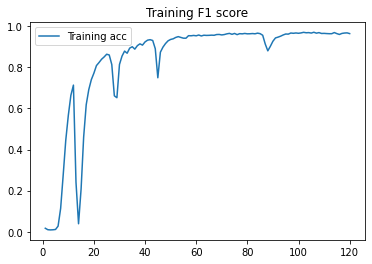

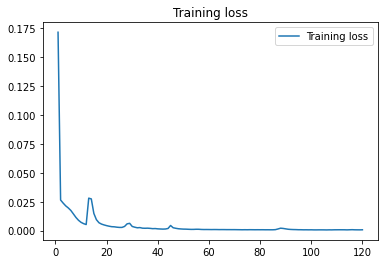

In [ ]:
model.load_weights(checkpoint_path)
loss = history.history['loss']
acc = history.history['f1_score']
import matplotlib.pyplot as plt

epochs = range(1, len(loss) + 1)
plt.plot(epochs, acc, label='Training acc')
plt.title('Training F1 score')
plt.legend()

plt.figure()
plt.plot(epochs, loss, label='Training loss')
plt.title('Training loss')
plt.legend()

plt.show()

In [ ]:
test_features = scaler.transform(test_features)
y_pred_test = model.predict(test_features)

25/25 [==============================] - 0s 2ms/step


In [ ]:
predicted_list = [i.tolist() for i in y_pred_test]
total_index_list = []
for i in predicted_list:
  index_list = []
  for j,k in enumerate(i):
    if k == 1:
      if j == 100:
        index_list.append('-1')
      else:
        index_list.append(str(j))
  if len(index_list) != 0:
    total_index_list.append(index_list)
  else:
    total_index_list.append([str(-1)])

predicted_str = []
for i in total_index_list:
  a = ','.join(i)
  predicted_str.append(a)

In [ ]:

df_output = pd.DataFrame({'ID': list(range(800)),'Predict':predicted_str})


In [ ]:
df_output.to_csv('predicted_result.csv',index = False)

In [ ]:


total_list = []
for i in y_pred_test:
  prediction_index = np.where(i >= 0.5)[0]
  total_list.append(prediction_index)


df = pd.DataFrame({'Predict':total_list})


In [ ]:
df

,Predict
0,[92]
1,[100]
2,[31]
3,[23]
4,[100]
...,...
795,[54]
796,[97]
797,[13]
798,[71]


In [ ]:
df.to_csv('prediction_file.csv')